In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import entropy, powerlaw
from scipy import interpolate
from scipy.optimize import curve_fit
import pandas as pd

In [3]:
df = pd.read_csv('../../projects/data/bolcom-clicks-35m_test.txt', sep='\t')
df


,SessionId,Time,ItemId
0,0008019740_18,1585897352,9200000083733268
1,0008019740_18,1585897382,9200000049819763
2,0008019740_18,1585897392,9200000066323079
3,0008019740_18,1585897506,9200000081546242
4,0008019740_18,1585897633,9200000125623273
...,...,...,...
1211470,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921127,9200000065118578
1211471,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921160,9200000065118570
1211472,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921286,9200000064417495
1211473,zzzjsuzmx87wcp4720be75zq67m2hkx9_14,1585944407,9200000026328200


In [4]:
def create_index_df_from_column(argument_df, columnname):
    # create an index for the training item_ids, because we need this when training the model
    # this should be part of the train and serve code of an algorithm
    # usage:
    #     create_index_df_from_column(df, 'ItemId')
    # returns a two column dataframe:
    #   ItemId  idx
    #   9200000105095118    0
    #   9200000041902190    1
    #   9200000095595490    2
    token_id = {t: i for i, t in enumerate(argument_df[columnname].unique())}
    df_index = pd.DataFrame.from_dict(token_id, orient="index").reset_index()
    df_index.rename(columns={"index": columnname, 0: "idx"}, inplace=True)
    return df_index

In [5]:
item_pop_df = df.groupby('ItemId').size()
item_pops_df = item_pop_df.to_frame('qty').reset_index()
item_pops_df.sort_values(by=['qty'], inplace=True)
item_idx = create_index_df_from_column(item_pops_df, 'ItemId')
dfs = item_pops_df.merge(item_idx, on='ItemId')
dfs

,ItemId,qty,idx
0,9200000092996478,1,0
1,9200000066211433,1,1
2,9200000123889779,1,2
3,9200000066211493,1,3
4,9200000066211497,1,4
...,...,...,...
338412,9200000110533529,2073,338412
338413,9200000056292168,2177,338413
338414,9200000026848187,2186,338414
338415,9200000047735877,2224,338415


In [27]:
# Observed frequencies to observed probability
f_obs = dfs['qty'].to_numpy()

In [28]:
# Fit the power law distribution to the observed probability of the items 
fit_params = powerlaw.fit(f_obs)

In [29]:
# Generate frequencies for new items
m = len(dfs)  # number of new items
f_new = powerlaw.rvs(*fit_params, size=m)
f_new = (np.rint(f_new)).astype(int)
f_new = np.sort(f_new)

f_new

array([   1,    1,    1, ..., 2336, 2336, 2336])

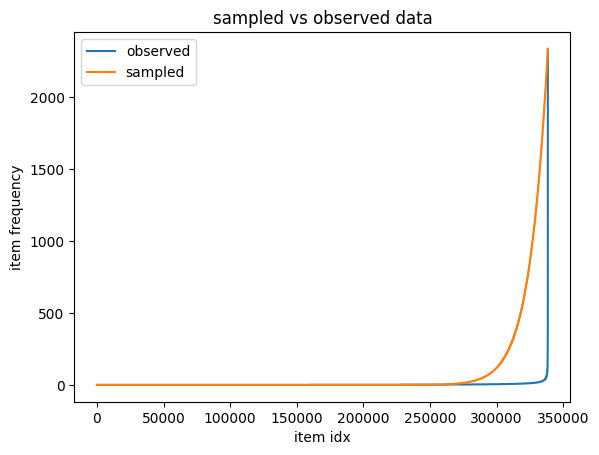

In [34]:
plt.title('sampled vs observed data')
plt.plot(f_obs, label='observed')
plt.plot(f_new, label='sampled')
plt.legend(loc='upper left')
plt.xlabel('item idx')
plt.ylabel('item frequency')
plt.show()

In [35]:
p_obs = f_obs / np.sum(f_obs)
p_new = f_new / np.sum(f_new)

In [36]:
kl_divergence_obs_synth = entropy(p_obs, p_new)
print(f"KL-divergence observed to synthetic: {kl_divergence_obs_synth}")
kl_divergence_synth_obs = entropy(p_new, p_obs)
print(f"KL-divergence synthetic to observed: {kl_divergence_synth_obs}")


KL-divergence observed to synthetic: 1.1901075508621057
KL-divergence synthetic to observed: 0.5900004653875549


In [37]:
mae = np.mean(np.abs(p_obs - p_new))  # mean absolute error
rmse = np.sqrt(np.mean(np.square(p_obs - p_new)))  # root mean squared error
ks = np.max(np.abs(np.cumsum(p_obs) - np.cumsum(p_new)))  # Kolmogorov-Smirnov statistic
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, KS: {ks:.4f}")

MAE: 0.0000, RMSE: 0.0000, KS: 0.4228
